In [ ]:
import numpy as np
import cv2
import os
import zipfile
from PIL import Image
import tensorflow as tf

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
pip install requests

In [ ]:
# Definir o endereço para baixar arquivo
!wget -P /content/drive/MyDrive/ELT579/Problema4 https://data.lhncbc.nlm.nih.gov/public/Malaria/cell_images.zip


--2023-11-30 19:49:40--  https://data.lhncbc.nlm.nih.gov/public/Malaria/cell_images.zip
Resolving data.lhncbc.nlm.nih.gov (data.lhncbc.nlm.nih.gov)... 108.138.94.6, 108.138.94.36, 108.138.94.100, ...
Connecting to data.lhncbc.nlm.nih.gov (data.lhncbc.nlm.nih.gov)|108.138.94.6|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 353452851 (337M) [application/zip]
Saving to: ‘/content/drive/MyDrive/ELT579/Problema4/cell_images.zip’

cell_images.zip     100%[===================>] 337.08M  41.4MB/s    in 7.0s    

2023-11-30 19:49:48 (48.1 MB/s) - ‘/content/drive/MyDrive/ELT579/Problema4/cell_images.zip’ saved [353452851/353452851]



In [ ]:
# Extrair conteúdo dos arquivos comprimidos
local_zip = '/content/drive/MyDrive/ELT579/Problema4/cell_images.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/content/drive/MyDrive/ELT579/Problema4')
zip_ref.close()

In [ ]:
pasta = '/content/drive/MyDrive/ELT579/Problema4/cell_images/'

positivas = os.listdir(pasta + 'Parasitized/')

negativas = os.listdir(pasta + 'Uninfected/')

In [ ]:
dataset = list()

label = list()

SIZE = 64

for i, image_name in enumerate(positivas):
  if(image_name.split('.')[1] == 'png'):
    img = cv2.imread(pasta + 'Parasitized/' + image_name)
    img = Image.fromarray(img, 'RGB')
    img = img.resize((SIZE, SIZE))
    dataset.append(np.array(img))
    label.append(1)

for i, image_name in enumerate(negativas):
  if(image_name.split('.')[1] == 'png'):
    img = cv2.imread(pasta + 'Uninfected/' + image_name)
    img = Image.fromarray(img, 'RGB')
    img = img.resize((SIZE, SIZE))
    dataset.append(np.array(img))
    label.append(0)

label =  0
imagem


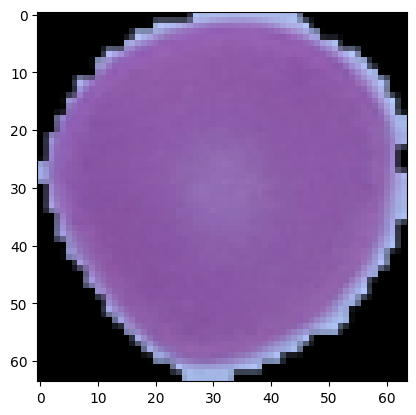

In [ ]:
import matplotlib.pyplot as plt

print('label = ', label[-2])

print('imagem')
plt.imshow(dataset[-2])

In [ ]:
X = np.array(dataset)

X = X/255.0

y = tf.keras.utils.to_categorical(np.array(label))



In [ ]:
print(np.shape(X))

(27558, 64, 64, 3)


In [ ]:
print(np.shape(y))

(27558, 2)


In [ ]:
print(y)

[[0. 1.]
 [0. 1.]
 [0. 1.]
 ...
 [1. 0.]
 [1. 0.]
 [1. 0.]]


In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20, random_state = 0)
X_train, X_val, y_train, y_val  = train_test_split(X_train, y_train, test_size=0.20, random_state=0)

In [ ]:
print(np.shape(X_train))

print(np.shape(y_train))

(17636, 64, 64, 3)
(17636, 2)


In [ ]:
print(np.shape(X_test))

print(np.shape(y_test))

(5512, 64, 64, 3)
(5512, 2)


In [ ]:
print(np.shape(X_val))

print(np.shape(y_val))

(4410, 64, 64, 3)
(4410, 2)


In [ ]:
import gc

gc.collect()

0

In [ ]:
gc.enable()

In [ ]:
def train_model(X_train, y_train, conv_nodes, dense_nodes, dropout_prob, lr, batch_size, epochs):
  nn_model = tf.keras.Sequential([
      tf.keras.layers.Conv2D(conv_nodes, kernel_size = (3,3), activation = 'relu', padding = 'same',  input_shape=(64,64,3)),
      tf.keras.layers.MaxPooling2D(pool_size = (2,2)),
      tf.keras.layers.Dropout(dropout_prob),
      tf.keras.layers.Conv2D(conv_nodes, kernel_size = (3,3), activation = 'relu', padding = 'same'),
      tf.keras.layers.MaxPooling2D(pool_size = (2,2)),
      tf.keras.layers.Dropout(dropout_prob),
      tf.keras.layers.Conv2D(conv_nodes, kernel_size = (3,3), activation = 'relu', padding = 'same'),
      tf.keras.layers.MaxPooling2D(pool_size = (2,2)),
      tf.keras.layers.Dropout(dropout_prob),
      tf.keras.layers.Flatten(),
      tf.keras.layers.Dense(dense_nodes, activation = 'relu'),
      tf.keras.layers.Dropout(rate = 0.2),
      tf.keras.layers.Dense(dense_nodes, activation = 'relu'),
      tf.keras.layers.Dropout(rate = 0.2),
      tf.keras.layers.Dense(2, activation= 'sigmoid'),
])

  nn_model.compile(optimizer=tf.keras.optimizers.Adam(lr), loss='binary_crossentropy',
                  metrics=['accuracy'])
  history = nn_model.fit(
    X_train, y_train, epochs=epochs, batch_size=batch_size, validation_split=0.2, verbose=0
  )

  return nn_model, history

In [ ]:
least_val_loss = float('inf')
least_loss_model = None
epochs=100
for conv_nodes in [32, 64, 128]:
  for dense_nodes in [256, 512]:
    for dropout_prob in [0, 0.2]:
     for lr in [0.01, 0.001, 0.005]:
        for batch_size in [32, 64, 128]:
            print(f"conv nodes {conv_nodes}, dense nodes {dense_nodes}, fc_nodes dropout {dropout_prob}, lr {lr}, batch size {batch_size}")
            model, history = train_model(X_train, y_train, conv_nodes, dense_nodes, dropout_prob, lr, batch_size, epochs)
            #plot_history(history)
            val_loss = model.evaluate(X_val, y_val)[0]
            if val_loss < least_val_loss:
              least_val_loss = val_loss
              least_loss_model = model

conv nodes 32, dense nodes 256, fc_nodes dropout 0, lr 0.01, batch size 32
75/75 [==============================] - 0s 4ms/step - loss: 0.2884 - accuracy: 0.9161
conv nodes 32, dense nodes 256, fc_nodes dropout 0, lr 0.01, batch size 64
75/75 [==============================] - 0s 3ms/step - loss: 0.1077 - accuracy: 0.9708
conv nodes 32, dense nodes 256, fc_nodes dropout 0, lr 0.01, batch size 128
75/75 [==============================] - 0s 3ms/step - loss: 0.2756 - accuracy: 0.9720
conv nodes 32, dense nodes 256, fc_nodes dropout 0, lr 0.005, batch size 32
75/75 [==============================] - 0s 3ms/step - loss: 0.2884 - accuracy: 0.9161
conv nodes 32, dense nodes 256, fc_nodes dropout 0, lr 0.005, batch size 64
75/75 [==============================] - 0s 3ms/step - loss: 0.3083 - accuracy: 0.9775
conv nodes 32, dense nodes 256, fc_nodes dropout 0, lr 0.005, batch size 128
75/75 [==============================] - 0s 3ms/step - loss: 0.2305 - accuracy: 0.9720
conv nodes 32, dense no

In [ ]:
model.save('malaria_least_loss_model.h5')

In [ ]:
from tensorflow.keras.models import load_model

model = load_model('malaria_least_loss_model.h5')

In [ ]:
y_pred = model.predict(X_test)
y_pred = y_pred.astype(int).reshape(-1,)
y_test = y_test.astype(int).reshape(-1,)

94/94 [==============================] - 1s 5ms/step


In [ ]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.89      1.00      0.94      2993
           1       1.00      0.88      0.94      2993

    accuracy                           0.94      5986
   macro avg       0.94      0.94      0.94      5986
weighted avg       0.94      0.94      0.94      5986

